# Bonsai ML Test

*Task*: Using the provided Mixpanel data of purchase histories, recommend a product that a user is most likely to buy next.

*Outline of methodology*: Collaborative filtering will be used alongside a popularity-based approach to account for user cold-start. For the collaborative filtering method, users that have bought fewer than 5 unique items will be set aside. Only those users who meet this threshold will be used to predict a personal rating for each product. A separate, popularity based model will however use all users in the dataset. This appraoch will use an implicit rating in the form of popularity (defined here as a function of product purchases and product returns) to predict ratings. These two ratings will be combined to give a final rating for each user-product pair.

## 0. Libraries

In [1]:
import json
import numpy as np
import pandas as pd

# pretty visuals
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# collaborative filtering
import surprise as s
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import SVD

## 1. Data

Begin by importing the data.

In [2]:
with open('training_mixpanel.txt') as rawdata:
    dicts = json.load(rawdata)

dicts[0]

{'event': 'Purchased Product',
 'properties': {'country': 'United Kingdom',
  'customer_id': 17850,
  'description': 'WHITE HANGING HEART T-LIGHT HOLDER',
  'invoice_date': '12/1/2010 8:26',
  'invoice_no': '536365',
  'product_id': '85123A',
  'quantity': 6,
  'unit_price': 2.55}}

Looking at the first key-value pair, we find that there is an inner dictionary containing the properties of each event.

In [3]:
# select the inner dictionary via 'properties' key
dicts[0].get('properties')

{'country': 'United Kingdom',
 'customer_id': 17850,
 'description': 'WHITE HANGING HEART T-LIGHT HOLDER',
 'invoice_date': '12/1/2010 8:26',
 'invoice_no': '536365',
 'product_id': '85123A',
 'quantity': 6,
 'unit_price': 2.55}

Let's make a separate list of all values for the "event" and "properties" keys.

In [4]:
# collect all 'event' and 'properties' keys in separate lists
event_list = []
properties_list = []
for i in range(len(dicts)):
    event_list.append(dicts[i].get('event'))
    properties_list.append(dicts[i].get('properties'))

In [5]:
# unique events in the data
set(event_list)

{'Purchased Product'}

Since they all have the same event: 'Purchased Product', goign forward we use only the values from properties.

In [6]:
properties = pd.DataFrame(properties_list)
properties.head()

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price
0,United Kingdom,17850,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,536365,85123A,6,2.55
1,United Kingdom,17850,WHITE METAL LANTERN,12/1/2010 8:26,536365,71053,6,3.39
2,United Kingdom,17850,SET 7 BABUSHKA NESTING BOXES,12/1/2010 8:26,536365,22752,2,7.65
3,United Kingdom,17850,GLASS STAR FROSTED T-LIGHT HOLDER,12/1/2010 8:26,536365,21730,6,4.25
4,United Kingdom,17850,HAND WARMER UNION JACK,12/1/2010 8:28,536366,22633,6,1.85


## 2. Data exploration and preprocessing

Check if there are any null values.

In [7]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322875 entries, 0 to 322874
Data columns (total 8 columns):
country         322875 non-null object
customer_id     322875 non-null int64
description     322875 non-null object
invoice_date    322875 non-null object
invoice_no      322875 non-null object
product_id      322875 non-null object
quantity        322875 non-null int64
unit_price      322875 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 19.7+ MB


Let's see if there is a need to remove potential duplicate rows (where all column values are repeated).

In [8]:
properties.drop_duplicates().shape

(318776, 8)

Since there are fewer rows here than in the original dataframe, we can drop duplicates.

In [9]:
properties = properties.drop_duplicates()

Look at the distribution of unit price and purchase quantity.

In [10]:
# summary of statistics for the distribution of unit price
properties['unit_price'].describe()

count    318776.000000
mean          2.940360
std           6.263049
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        1100.440000
Name: unit_price, dtype: float64

In [11]:
# summary of statistics for the distribution of quantity
properties['quantity'].describe()

count    318776.000000
mean         12.229004
std         280.085461
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: quantity, dtype: float64

There seem to be items with negative quantity values. Looking at a few of these rows, they are likely returned products. 

In [12]:
properties.loc[properties['quantity'] < 0].head()

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price
117,United Kingdom,15311,SET OF 3 COLOURED FLYING DUCKS,12/1/2010 9:49,C536383,35004C,-1,4.65
187,United Kingdom,17548,PLASTERS IN TIN CIRCUS PARADE,12/1/2010 10:24,C536391,22556,-12,1.65
188,United Kingdom,17548,PACK OF 12 PINK PAISLEY TISSUES,12/1/2010 10:24,C536391,21984,-24,0.29
189,United Kingdom,17548,PACK OF 12 BLUE PAISLEY TISSUES,12/1/2010 10:24,C536391,21983,-24,0.29
190,United Kingdom,17548,PACK OF 12 RED RETROSPOT TISSUES,12/1/2010 10:24,C536391,21980,-24,0.29


There are however products in the dataset that have only been returned, but not bought. Likewise there are users who only have a record of returning an item.

In [13]:
print('products with no record of purchase, but that have been returned:',
      properties['product_id'].nunique() - properties.loc[properties['quantity'] >= 0]['product_id'].nunique())
print('customers with no record of purchase, but that have returned items:',
      properties['customer_id'].nunique() - properties.loc[properties['quantity'] >= 0]['customer_id'].nunique())

products with no record of purchase, but that have been returned: 18
customers with no record of purchase, but that have returned items: 28


Let's create a column that will contain the rate of return for each item, i.e. the ratio of total purchases to total returns. This will be used to calculate product popularity later.

In [14]:
def rate_of_return(df=properties):

    ''' The ratio of purchases to returns of each product. '''
    
    # first, add a column indicating the return count of an item on a single invoice
    df.loc[df['quantity'] >= 0, 'product_return_count'] = 0
    df.loc[df['quantity'] < 0, 'product_return_count'] = -1*df['quantity']
    # next, add a column indicating the total number of times an item was returned
    num_product_returned = df.groupby('product_id')['product_return_count'].sum()
    df = df.join(num_product_returned.to_frame(name='num_product_returned'), on='product_id')
    
    # disregard information on returned products (just for the below aggregate)
    products_purchased = df.loc[df['quantity'] >= 0]
    # then, add a column containing the total number of times an item was purchased
    num_product_purchased = products_purchased.groupby(['product_id'])['quantity'].sum()
    df = df.join(num_product_purchased.to_frame(name='num_product_purchased'), on='product_id')

    # replace null values with 0, indicating this product has no purchase info (purchased 0 times)
    df['num_product_purchased'] = df['num_product_purchased'].fillna(0)
    # define product return rate; note that there will be division by 0
    df['product_return_rate'] = df['num_product_returned'] / df['num_product_purchased']
    # and replace inf (from previous division by 0) with null
    df['product_return_rate'] = df['product_return_rate'].replace([np.inf,-np.inf], np.nan)

    # replace null values with the maximal return rate
    max_return_rate = df['product_return_rate'].max()
    df['product_return_rate'] = df['product_return_rate'].fillna(max_return_rate)
    
    # finally, drop the new columns that aren't needed (num_product_purchased will be used later)
    df = df.drop(['product_return_count','num_product_returned'], axis=1)

    return df

In [15]:
properties = rate_of_return()
properties.head()

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price,num_product_purchased,product_return_rate
0,United Kingdom,17850,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,536365,85123A,6,2.55,27324.0,0.093874
1,United Kingdom,17850,WHITE METAL LANTERN,12/1/2010 8:26,536365,71053,6,3.39,1494.0,0.022758
2,United Kingdom,17850,SET 7 BABUSHKA NESTING BOXES,12/1/2010 8:26,536365,22752,2,7.65,1361.0,0.088905
3,United Kingdom,17850,GLASS STAR FROSTED T-LIGHT HOLDER,12/1/2010 8:26,536365,21730,6,4.25,439.0,0.027335
4,United Kingdom,17850,HAND WARMER UNION JACK,12/1/2010 8:28,536366,22633,6,1.85,3156.0,0.003169


Let's quickly see the distribution of return rates. Most seem to lie between 0 and 0.02.

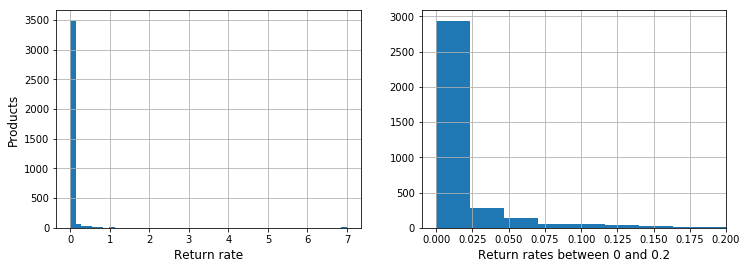

In [16]:
# dataframe containing info on unique products
unique_products_only = properties.drop_duplicates(subset='product_id')

fig = plt.figure(figsize=(12,4))

# return rate histogram
returnfig = fig.add_subplot(121)
unique_products_only['product_return_rate'].hist(bins=50)
returnfig.set_xlabel("Return rate", fontsize=12)
returnfig.set_ylabel("Products", fontsize=12)

# return rate histogram for rates in [0,0.2]
returnfig = fig.add_subplot(122)
unique_products_only['product_return_rate'].hist(bins=300)
returnfig.set_xlim(-0.01,0.2)
returnfig.set_xlabel("Return rates between 0 and 0.2", fontsize=12)

Some of the following visualizations helped guide my initial thinking of the methodology, but the features they use were not used in the actual recommendation system. But I have kept them anyway.

### Datetime
Let's look at some datetime trends of product interactions (an interaction here is either a purchase or return).

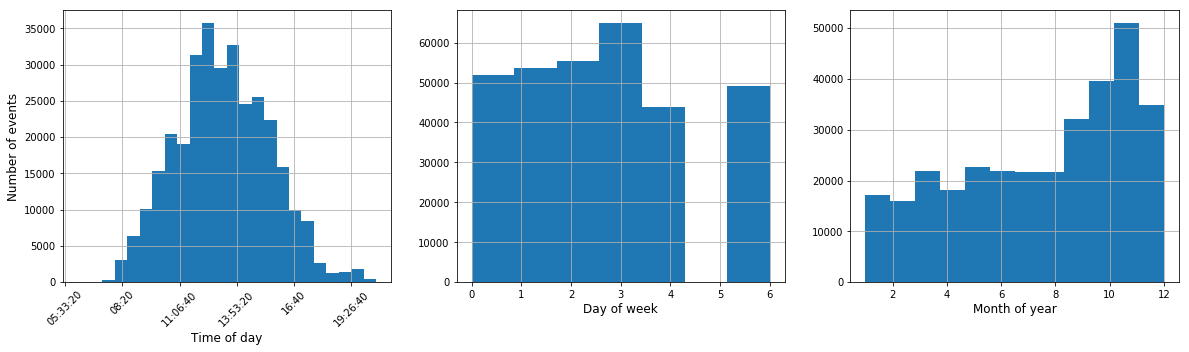

In [17]:
# split datetime into date and time columns
properties['date'], properties['time'] = properties['invoice_date'].str.split(' ', 1).str

# extract datetime properties
time_of_day = pd.to_datetime(properties['time']).dt.time
day_of_week = pd.to_datetime(properties['date']).dt.dayofweek
month_of_year = pd.to_datetime(properties['date']).dt.month

fig = plt.figure(figsize=(20,5))

# time of day histogram
timefig = fig.add_subplot(131)
time_of_day.hist(bins=24, xrot=45)
timefig.set_xlabel("Time of day", fontsize=12)
timefig.set_ylabel("Number of events", fontsize=12)

# day of week histogram
dayfig = fig.add_subplot(132)
day_of_week.hist(bins=7)
dayfig.set_xlabel("Day of week", fontsize=12)

# month of year histogram
monthfig = fig.add_subplot(133)
month_of_year.hist(bins=12)
monthfig.set_xlabel("Month of year", fontsize=12)

### Description

A wordcloud of product descriptions.

(-0.5, 1299.5, 865.5, -0.5)

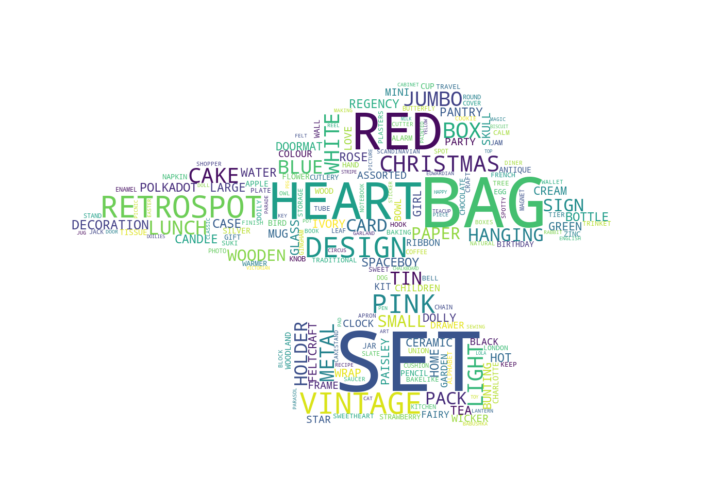

In [18]:
# convert product descriptions to usable strings for word cloud
description_text = properties['description'].to_string()

# set stop-words, so words like "the" and "it" are ignored
stopwords = set(STOPWORDS)

# import image and make it usable by word cloud
bonsai = np.array(Image.open('bonsai.jpg'))

fig = plt.figure(figsize=(12,12))

# description cloud
wordcloud = WordCloud(background_color='white', 
                      mask=bonsai, 
                      collocations=False, 
                      stopwords=stopwords).generate(description_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Country

Piechart of country names.

(-1.10040935122487, 1.10001949291547, -1.105887355060017, 1.105699577743399)

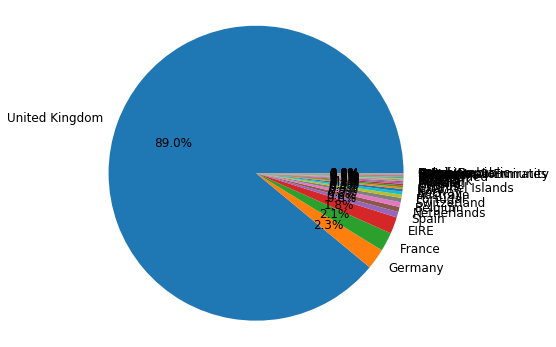

In [19]:
properties.country.value_counts().plot(kind='pie', 
                                      figsize=(8,6), 
                                      fontsize=12, 
                                      autopct='%1.1f%%', 
                                      wedgeprops={'linewidth':5}
                                      )
plt.axis('off')
plt.axis('equal')

Now before moving on, let's drop the columns that will not be used from this point on.

In [20]:
properties = properties.drop(['country',
                              'description',
                              'invoice_date',
                              'date',
                              'time'], axis=1)

## 3. Popularity-based approach

Let's begin the recommendation process. In this section, we'll use popularity of items to predicts ratings for each product. First we define popularity to be be function of the total number of times an item was purchased, and the rate of return of that item. Another column added that contains the number of unique items each user has bought. This will play the role of giving a weight to the popularity ratings. The reason is this: Users that have bought fewer items will have a product's popularity rating play a larger role in determining their final rating for the product. Whereas users who have bought many products will have a lower weight for the popularity rating, but a higher weight for the collaborative filtering rating. 

In [21]:
def product_popularity(df=properties):
    
    ''' The popularity of a product is a function of the purchase count and return rate. '''
    
    # popularity = (number of purchases) x (1 - return rate)
    df['popularity'] = df['product_return_rate'].apply(lambda x: 1-x) * df['num_product_purchased']
    # rescale popularity to get rating
    df['popularity_rating'] = (df['popularity']-df['popularity'].min()) / (df['popularity'].max()-df['popularity'].min())
    
    # introduce column for the number of unique products purchased by a customer
    num_unique_products = df.groupby('customer_id')['product_id'].nunique()
    df = df.join(num_unique_products.to_frame(name='customer_unique_products'), on='customer_id')
        
    df = df.drop(['popularity', 'num_product_purchased'], axis=1)
        
    return df   

In [22]:
properties = product_popularity()
properties.head()

,customer_id,invoice_no,product_id,quantity,unit_price,product_return_rate,popularity_rating,customer_unique_products
0,17850,536365,85123A,6,2.55,0.093874,0.602897,17
1,17850,536365,71053,6,3.39,0.022758,0.104320,17
2,17850,536365,22752,2,7.65,0.088905,0.099613,17
3,17850,536365,21730,6,4.25,0.027335,0.082215,17
4,17850,536366,22633,6,1.85,0.003169,0.140399,17


What does the distribution look like for the unique product count of each user?

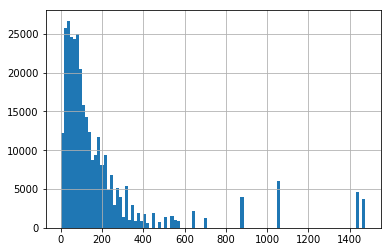

In [23]:
properties['customer_unique_products'].hist(bins=100)

### Methodology

This tells us that most users have bought around 100 unique products. Any such user (with 100 or more unique product purchases) does not need much, if any, input from a model that rates products based solely on product popularity. What we can then do is clip the "customer_unique_products" values to an upper threshold of 100. This means anything above 100 will be replaced with 100. To reinforce the notion that users with more than 100 unique product purchases will not be affected by the popularity-based approach, we do the following: 
* Log-scale (base 10) the unique product counts, so that the min count: $1\: -> \log{1} = 0$, and the max count: $100\: -> \log{100} = 2$.
* Subtract each log-scaled value by its max of 2, so that min count: $0\: -> 2$, and the max count: $2\: -> 0$. Call this the popularity rating's weight $w_p^{ij}$ associated to product $i$ and user $j$. Higher the weight, fewer the unique products for a user.
* Define weighted popularity rating $r_p^{ij}$ to be $r_p^{ij} = w_p^{ij} * p^i$, where $p^i$ is the popularity of product $i$. As an example, if product $m$ has a popularity (from column "popularity_rating") of 0.8, and a popularity weight 1.3 for user $n$ (indicating that this is a user who has bought only a few products), we get a weighted popularity rating of:
$$r_p^{mn} = w_p^{mn} * p^m = 0.8*1.3 = 1.04.$$

And here's how the ratings predicted by collaborative filtering will be accounted for:
* For product $i$ and user $j$, let $r_c^{ij}$ be the rating predicted by collaborative filtering (computed after this section).
* Then, final rating is a weighted average:

$$R^{ij} = \left[(2-\text{popularity_weight})*r_c^{ij} + \text{popularity_weight}*r_p^{ij}\right]/2.$$

As an example, consider again the product-user pair $(m,n)$. Let's say this user has a predicted rating of $r_c^{ij}=0.5$ from collaborative filtering. Since the popularity weight of this user is 1.3, their final predicted rating for the product will be:

$$ R^{ij} = \left[(2-1.3)*0.5 + 1.3*0.8\right]/2 = 0.695.$$

Which is a rating that is closer to the popularity based rating of 0.8. As a check, a weight of 1.3 means that the original log-scaled unique product count was $2-1.3=0.7$, which corresponds to the user having bought 5 unique products. So it makes sense that this user's recommended score for an item will be a bit more influenced by the popularity-based approach.

Continuing with the popularity approach, let's clip and logscale the values as previously discussed.

In [24]:
def clip_and_scale_uniquecount(df=properties):

    ''' Clips and scales the number of unique product purchases of each user. '''
    
    # clip values outside boundary to boundary values 
    df['customer_unique_products'].clip(lower=1, upper=100, inplace=True)
    # log scale
    df['customer_unique_products_logscale'] = df['customer_unique_products'].apply(lambda x: np.log10(x))
    
    # subtract values by their maximum; global variable to be used later as well
    global logscale_max
    logscale_max = df['customer_unique_products_logscale'].max()
    df['popularity_weight'] = df['customer_unique_products_logscale'].apply(lambda x: logscale_max - x)
    
    # drop columns that won't be needed
    df = df.drop(['customer_unique_products','customer_unique_products_logscale'], axis=1)
    
    return df

In [25]:
properties = clip_and_scale_uniquecount()
properties.head()

,customer_id,invoice_no,product_id,quantity,unit_price,product_return_rate,popularity_rating,popularity_weight
0,17850,536365,85123A,6,2.55,0.093874,0.602897,0.769551
1,17850,536365,71053,6,3.39,0.022758,0.104320,0.769551
2,17850,536365,22752,2,7.65,0.088905,0.099613,0.769551
3,17850,536365,21730,6,4.25,0.027335,0.082215,0.769551
4,17850,536366,22633,6,1.85,0.003169,0.140399,0.769551


In [26]:
# maximum value for the logscaled unique product purchases
logscale_max

2.0

In [27]:
rating_weights = properties.groupby('customer_id')['popularity_weight'].unique().reset_index()
rating_weights['popularity_weight'] = rating_weights['popularity_weight'].astype(float)
rating_weights.head()

,customer_id,popularity_weight
0,12346,2.000000
1,12347,0.000000
2,12348,0.698970
3,12349,0.142668
4,12350,0.795880


In [28]:
popularity_ratings = properties.groupby('product_id')['popularity_rating'].unique().reset_index()
popularity_ratings['popularity_rating'] = popularity_ratings['popularity_rating'].astype(float)
popularity_ratings.head()

,product_id,popularity_rating
0,10002,0.090689
1,10080,0.079305
2,10120,0.077186
3,10123C,0.073185
4,10124A,0.073420


Seeing as we'd like to create a matrix of user-product ratings, let's do an outer product on the above two dataframes.

In [29]:
weighted_popularity_matrix = np.outer(np.array(rating_weights['popularity_weight']),
                                      np.array(popularity_ratings['popularity_rating']))

Check to see if the matrix shape makes sense.

In [30]:
print('customers in dataset:', properties['customer_id'].nunique())
print('products in dataset:', properties['product_id'].nunique())
print('shape of matrix:', weighted_popularity_matrix.shape)

customers in dataset: 4363
products in dataset: 3677
shape of matrix: (4363, 3677)


Note that a similar weighted matrix will be created for the collaborative filtering model, and an element-wise average will be taken to get the final ratings.

## 4. Collaborative filtering

Create a separate dataframe that contains only those rows where customers have purchased at least 5 unique products. This data will be used for collaborative filtering.

In [31]:
def interaction_threshold(df=properties, threshold=3):

    ''' Creates a dataframe with users that have bought more than "threshold" products. '''

    num_user_interactions = df.groupby(['customer_id','product_id']).size().groupby('customer_id').size()
    print('users: %d' % len(num_user_interactions))
    above_threshold_user_interactions = num_user_interactions[num_user_interactions >= threshold].reset_index()[['customer_id']]
    print('users that have purchased at least', threshold, 'items: %d' % len(above_threshold_user_interactions))
    
    # list of users that are below threshold; global variable will be used later
    global below_threshold_user_interactions
    below_threshold_user_interactions = num_user_interactions[num_user_interactions < threshold].reset_index()[['customer_id']]
    print('users that have purchased fewer than', threshold, 'items: %d' % len(below_threshold_user_interactions))

    # thresholded dataframe obtained from properties dataframe
    df_thresholded = df.merge(above_threshold_user_interactions, 
                              how='right', 
                              left_on='customer_id', 
                              right_on='customer_id')
    print('')
    print('products: %d' % df['product_id'].nunique())
    print('products after threshold: %d' % df_thresholded['product_id'].nunique())
    print('interactions: %d' % len(df))
    print('interactions after threshold: %d' % len(df_thresholded))    
    
    return df_thresholded

In [32]:
properties_thresh = interaction_threshold()

users: 4363
users that have purchased at least 3 items: 4176
users that have purchased fewer than 3 items: 187

products: 3677
products after threshold: 3677
interactions: 318776
interactions after threshold: 318443


187 users did not meet the cutoff. That's okay, because they will instead be recommended products based on product popularity. This means that if a user has not yet made at least 5 purchases, they will be recommended items that are just generally popular among other user. 

Now let's ascribe an implicit rating to each interaction equal to (a scaled version of) quantity x price. So here, a rating will just be the total amount of money a user spent on each item. The following creates a dataframe of unique user-item pairs, along with quantity x price.

In [33]:
properties_thresh['total_price'] = properties_thresh['quantity'] * properties_thresh['unit_price']
properties_thresh = properties_thresh.drop(['quantity','unit_price'], axis=1)
customer_product_interactions = properties_thresh.groupby(['customer_id', 'product_id'])['total_price'].sum().reset_index()
customer_product_interactions.rename(columns={'total_price':'total_user_product_price'}, inplace=True)

In [34]:
customer_product_interactions.total_user_product_price.describe()

count    213406.000000
mean         30.305946
std         147.329205
min       -7933.430000
25%           5.100000
50%          13.900000
75%          22.500000
max       16027.920000
Name: total_user_product_price, dtype: float64

There appear to be outliers. Let's clip them to boundary values and rescale to the interval [0,1].

In [35]:
def clip_and_scale_interactions(df=customer_product_interactions, num_std=0.1):
    
    ''' Clips and scales the rating for each user-product pair. '''
    
    col = 'total_user_product_price'
    average = df[col].mean()
    threshold = df[col].std() * num_std
    # clip values outside boundary to boundary values
    df[col].clip(lower=-threshold, upper=average+threshold, inplace=True)
    # rescale between [0,1]
    df['scaled_user_product_price'] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
    df = df.drop(col, axis=1)
    
    return df

In [36]:
customer_product_interactions = clip_and_scale_interactions()
customer_product_interactions.scaled_user_product_price.describe()

count    213406.000000
mean          0.526638
std           0.231544
min           0.000000
25%           0.331811
50%           0.479037
75%           0.622918
max           1.000000
Name: scaled_user_product_price, dtype: float64

### Surprise

We use the [Surprise](http://surprise.readthedocs.io/en/stable/) library, which allows you to do collaborative filtering with a few simple lines of code. First the data is loaded in a manner required by surprise. Then the [SVD algorithm](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) is used with rmse (root mean sqaured error). A few other prediction algorithms were tried, but SVD gave the best result.

In [37]:
data = s.Dataset.load_from_df(customer_product_interactions[['customer_id','product_id','scaled_user_product_price']],
                              rating_scale=(0,1))
trainset, testset = train_test_split(data, test_size=.2)

In [38]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
s.accuracy.rmse(predictions)

RMSE: 0.1764


0.17637220749026292

The predictions module stores the results of a prediction in the following format:

In [39]:
predictions[0]

Prediction(uid=18160, iid='71459', r_ui=0.41713526755220803, est=0.5787700975533147, details={'was_impossible': False})

* uid - user id
* iid - item id
* r_ui - true rating
* est - estimated rating
* details - additional details about the prediction

The next step is to get ratings for each product for all the users. Then:
* Make a dataframe with (customers X products) rows containing unique customer-product pairs.
* Use the above predictions module to predict all the ratings.

In [40]:
customers_df_thresh = properties_thresh.customer_id.to_frame(name='customer_id')
customers_df_thresh['key'] = 0
customers_df_thresh = customers_df_thresh.drop_duplicates()

products_df_thresh = properties_thresh.product_id.to_frame(name='product_id')
products_df_thresh['key'] = 0
products_df_thresh = products_df_thresh.drop_duplicates()

# put all customer-product pairs in a dataframe
full_customer_product_thresh = pd.merge(customers_df_thresh, products_df_thresh, on='key').drop('key', axis=1)
full_customer_product_thresh['collabfilter_ratings'] = 0
print(full_customer_product_thresh.info())
full_customer_product_thresh.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15355152 entries, 0 to 15355151
Data columns (total 3 columns):
customer_id             int64
product_id              object
collabfilter_ratings    int64
dtypes: int64(2), object(1)
memory usage: 468.6+ MB
None


,customer_id,product_id,collabfilter_ratings
0,17850,85123A,0
1,17850,71053,0
2,17850,22752,0
3,17850,21730,0
4,17850,22633,0


Next, to predict ratings for the above dataset, we load it into surprise and convert to array (after loading), and this seems to make things easier.

In [41]:
data2 = s.Dataset.load_from_df(full_customer_product_thresh[['customer_id', 'product_id', 'collabfilter_ratings']],
                              rating_scale=(0,1))
data2 = np.array(full_customer_product_thresh)

Due to the large size of data2 (15,355,152 rows), I will do the following:
* Split the data into thirds
* Separately generate predictions on each third
* Combine into one set of predictions
* Convert to numpy array

In [42]:
first_third_predictions = algo.test(data2[:int(15355152 * 1/3)])

In [43]:
second_third_predictions = algo.test(data2[int(15355152 * 1/3):int(15355152 * 2/3)])

In [44]:
last_third_predictions = algo.test(data2[int(15355152 * 2/3):])

In [45]:
# combining all thirds into one set of predictions
all_collabfilter_predictions = first_third_predictions + second_third_predictions + last_third_predictions
# converting to array for ease of use
all_collabfilter_predictions = np.array(all_collabfilter_predictions)

# sample prediction
all_collabfilter_predictions[0]

array([17850, '85123A', 0, 0.9266235592686055, {'was_impossible': False}],
      dtype=object)

We only need the first, second, and fourth slices from this array (customer, product, and predicted rating).

In [46]:
customer_product_ratings_collabfilter = all_collabfilter_predictions[:,[0,1,3]]

Recall that we have a notion of weights for ratings. Let's calculate these weights for collaborative filtering (2 - popularity_weight).

In [47]:
# rating weights for collaborative filtering
collabfilter_weights = rating_weights
collabfilter_weights['cf_weight'] = collabfilter_weights['popularity_weight'].apply(lambda x: logscale_max - x)
collabfilter_weights = collabfilter_weights.drop('popularity_weight', axis=1)
collabfilter_weights.head()

,customer_id,cf_weight
0,12346,0.000000
1,12347,2.000000
2,12348,1.301030
3,12349,1.857332
4,12350,1.204120


I'll merge this dataframe of weights with the "customer_product_ratings_collabfilter", so that scaling the ratings (in "customer_product_ratings_collabfilter") can be rescaled by weights (in "collabfilter_weights") by simple column multiplication. 

In [48]:
# convert to dataframe
customer_product_ratings_collabfilter = pd.DataFrame(data=customer_product_ratings_collabfilter,
                                                     columns=['customer_id','product_id','collabfilter_ratings'])

Before proceeding, let's change the datatype of "customer_id" and "collabfilter_ratings" to int and float, respectively. This is done so that datatypes are the same for columns when merging (for instance customer_id is type int in one dataframe, but type object in the other).

In [49]:
customer_product_ratings_collabfilter['customer_id'] = customer_product_ratings_collabfilter['customer_id'].astype(int)
customer_product_ratings_collabfilter['collabfilter_ratings'] = customer_product_ratings_collabfilter['collabfilter_ratings'].astype(float)

Let's now merge the above with the weights data. This will then provide us with a way to scale ratings.

In [50]:
# merge ratings and weights data
weighted_collabfilter_df = pd.merge(customer_product_ratings_collabfilter, 
                                     collabfilter_weights, 
                                     on='customer_id', 
                                     how='left')
weighted_collabfilter_df.head()

,customer_id,product_id,collabfilter_ratings,cf_weight
0,17850,85123A,0.926624,1.230449
1,17850,71053,0.814476,1.230449
2,17850,22752,0.882449,1.230449
3,17850,21730,0.767386,1.230449
4,17850,22633,0.747036,1.230449


In [51]:
# scale ratings by weights
weighted_collabfilter_df['weighted_cf_ratings'] = weighted_collabfilter_df['collabfilter_ratings'] * weighted_collabfilter_df['cf_weight']
weighted_collabfilter_df = weighted_collabfilter_df.drop(['collabfilter_ratings','cf_weight'], axis=1)
weighted_collabfilter_df.head()

,customer_id,product_id,weighted_cf_ratings
0,17850,85123A,1.140163
1,17850,71053,1.002171
2,17850,22752,1.085808
3,17850,21730,0.944230
4,17850,22633,0.919190


At this stage, we have a dataframe comtaining the weighted rating predictions for each user-product pair. Or rather for each user that wasn't discarded when we introduced the threshold for minumum unique products. In order to get a complete recommendation list that includes all user-product pairs, let's now create a similar dataframe containing only those 187 users that were below threshold. Recall the global variable "below_threshold_user_interactions". This contains all such users. Let's merge this with the original properties dataframe and use the process from before to generate user-product pairs.

In [52]:
# dataframe containing only those rows where users are below threshold of unique product interactions
properties_below_thresh = pd.merge(properties, 
                                   below_threshold_user_interactions, 
                                   on='customer_id')

customers_df_below_thresh = properties_below_thresh.customer_id.to_frame(name='customer_id')
customers_df_below_thresh['key'] = 0
customers_df_below_thresh = customers_df_below_thresh.drop_duplicates()

# put all customer-product pairs in a dataframe (below threshold customers only, but using all products)
full_customer_product_below_thresh = pd.merge(customers_df_below_thresh, 
                                            products_df_thresh, # all products
                                            on='key').drop('key', axis=1)
# naming the column the same as the previous dataframe so that we can easily append it there
full_customer_product_below_thresh['weighted_cf_ratings'] = 0

print(full_customer_product_below_thresh.info())
full_customer_product_below_thresh.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687599 entries, 0 to 687598
Data columns (total 3 columns):
customer_id            687599 non-null int64
product_id             687599 non-null object
weighted_cf_ratings    687599 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.0+ MB
None


,customer_id,product_id,weighted_cf_ratings
0,15100,85123A,0
1,15100,71053,0
2,15100,22752,0
3,15100,21730,0
4,15100,22633,0


Finally to get all user-product pairs and their collaborative filtering ratings, we append this below-threshold dataframe to the other.

In [53]:
weighted_collabfilter_df = weighted_collabfilter_df.append(full_customer_product_below_thresh, sort=False)

# sort first by customer_id then by product_id to ensure correct ordering of ratings
weighted_collabfilter_df = weighted_collabfilter_df.sort_values(by=['customer_id','product_id'])

Now we generate a similar MxN matrix of ratings to the one in the previous section (popularity ratings). We will add these two matrices element-wise and take an average. Then we save it as a csv file.

In [54]:
# unique products and customers in original dataset
M = properties.customer_id.nunique()
N = properties.product_id.nunique()

# weighted matrix of ratings determined by collaborative filtering
weighted_collabfilter_matrix = np.array(weighted_collabfilter_df.weighted_cf_ratings)
weighted_collabfilter_matrix = weighted_collabfilter_matrix.reshape(M,N)

# final ratings are a weighted average
final_ratings = 0.5*np.add(weighted_collabfilter_matrix,weighted_popularity_matrix)
# converting the array first to a pandas dataframe seems to reduce filesize
final_ratings = pd.DataFrame(data=final_ratings)

# save
final_ratings.to_csv('ratings.csv')

## 5. Conclusion

One of the things I would like to try, given more time, is use the product description column. For the popularity-based approach, this would come in the form of generating feature vectors using TF-IDF and compute similarity between the descriptions. A notion of user profile would be needed for all products bought/returned by the user. These profiles would use the TF-IDF vectors for each product that user has interacted with. When trying this very approach, I ran into a huge time constraint. Creating all profiles would take over a day on my computer so I decided against using it, and went with implicit ratings based on the popularity score I defined earlier. Given more time I would determine an efficitent way to include product descriptions in the popularity-based approach, as that would likely give a closer rating. 